# Component_based Normalization Algorithm for mCT 1104 Scanner
Hamidreza Rashidy Kanan,
2023

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from datetime import datetime
import scipy.ndimage
import sys

In [2]:
import odl
from odl.operator import Operator
from odl.discr import uniform_discr

In [3]:
%run load_shared_libraries.py #python script to load shared libraried for SIRF

In [4]:
sys.path.append('/home/hamidreza/devel/build/INSTALL/python')
sys.path.append('/home/hamidreza/devel/build/INSTALL/lib')
sys.path.append('/home/hamidreza/devel/build/sources')

In [5]:
import sirf
from sirf.STIR import *
set_verbosity(0)
AcquisitionData.set_storage_scheme('memory') #storage in memory

## 2. Read the Normalization File, Created by the Scanner

In [6]:
"""
*********************************************************************
Reconstruction Framework for Siemens Biograph 128 mCT-1104.  
*********************************************************************
function [componentFactors, componentLabels]  = readmCTComponentBasedNormalization(filenameRawData, visualize)
 
This functions read the component based normalization file of the mCT.
Receives two parameters:
-filenameRawData: the name of the file with the raw data(*.n).
-visualize: flag to indicate if a visualization of each factor is
desired.

The ouput is two cell arrays:
-componentFactors: each element of this cell array is a matrix or
vector with one of the component of the normalization.
-componentLabels: cell array of the same size of componentFactors,
where each of the elements is the name of the component. 
 
The size of each component matrix are hardcoded for the mCT scanner and
are taken from the following specification of the interfile header:

NORMALIZATION COMPONENTS DESCRIPTION:
 
number of normalization components:=7
normalization component [1]:=geometric effects
normalization component [2]:=crystal interference
normalization component [3]:=crystal efficiencies
normalization component [4]:=axial effects
normalization component [5]:=paralyzing ring DT parameters
normalization component [6]:=non-paralyzing ring DT parameters
normalization component [7]:=TX crystal DT parameter

data offset in bytes [1]:=0
data offset in bytes [2]:=174400
data offset in bytes [3]:=196800
data offset in bytes [4]:=344640
data offset in bytes [5]:=347124
data offset in bytes [6]:=347344
data offset in bytes [7]:=347564
 

number of dimensions [1]:=2
number of dimensions [2]:=2
number of dimensions [3]:=2
number of dimensions [4]:=1
number of dimensions [5]:=1
number of dimensions [6]:=1
number of dimensions [7]:=1
 
matrix size [1]:={400,109}
matrix size [2]:={14,400}
matrix size [3]:={672,55}
matrix size [4]:={621}
matrix size [5]:={55}
matrix size [6]:={55}
matrix size [7]:={14}
 
matrix axis label [1]:={sinogram projection bins,sinogram planes}
matrix axis label [2]:={crystal number,sinogram projection bins}
matrix axis label [3]:={crystal number,ring number}
matrix axis label [4]:={plane number}
matrix axis label [5]:={ring number}
matrix axis label [6]:={ring number}
matrix axis label [7]:={crystal number}
"""
import numpy as np
import matplotlib.pyplot as plt
norm_path = '/home/hamidreza/data/PSKTH0107/output/PET-RAW-DATA-norm.n'

def readmCTComponentBasedNormalization(norm_path, visualize):
    # Open file
    with open(norm_path, 'rb') as f:
        # Read all the files from the specification, the sizes are fixed
        # but it would be better to take the size from the interfile header
        geomEffects = np.fromfile(f, dtype=np.float32, count=400*109).reshape(109, 400).T
        crystalInterf = np.fromfile(f, dtype=np.float32, count=14*400).reshape(400, 14).T
        crystalEff = np.fromfile(f, dtype=np.float32, count=672*55).reshape(55, 672).T
        axialEffects = np.fromfile(f, dtype=np.float32, count=621)
        parRingDt = np.fromfile(f, dtype=np.float32, count=55)
        nonParRingDt = np.fromfile(f, dtype=np.float32, count=55)
        txCrystalDt = np.fromfile(f, dtype=np.float32, count=14)


    componentFactors = [geomEffects, crystalInterf, crystalEff, axialEffects,
                         parRingDt, nonParRingDt, txCrystalDt]
    componentLabels = ['Geometric Effects', 'Crystal Interference', 'Crystal Efficiencies',
                        'Axial Effects', 'Paralyzing Dead Time', 'Non-Paralyzing Dead Time',
                        'Transmission Dead Time']
    matrix_axis_labels =[("Sinogram Projection Bins","Sinogram Planes"),
                    ("Crystal Number","Sinogram Projection Bins"),
                    ("Crystal Number","Ring Number"),
                    "Plane Number",
                    "Ring Number",
                    "Ring Number",
                    "Crystal Number"]

    

    if visualize:
        # Plot the normalization parameters
        plt.figure(figsize=(10, 8))
        plt.imshow(geomEffects, cmap='hot')
        plt.title(componentLabels[0])
        plt.colorbar()
        plt.xlabel(matrix_axis_labels[0][1])
        plt.ylabel(matrix_axis_labels[0][0])

        plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        plt.imshow(crystalInterf / np.max(crystalInterf))
        plt.title(componentLabels[1])
        plt.xlabel(matrix_axis_labels[1][1])
        plt.ylabel(matrix_axis_labels[1][0])
        plt.subplot(2, 1, 2)
        plt.imshow(crystalEff.T / np.max(crystalEff))
        plt.title(componentLabels[2])
        plt.xlabel(matrix_axis_labels[2][0])
        plt.ylabel(matrix_axis_labels[2][1])

        plt.figure(figsize=(10, 8))
        for i in range(10):
            plt.plot(crystalEff[:, i])
        plt.title('Crystal Efficiencies for the First 10 Rings')
        plt.xlabel('Crystal Number')
        plt.ylabel('Efficiency')
        plt.legend(['Ring {}'.format(i) for i in range(10)])

        plt.figure(figsize=(10, 8))
        plt.plot(axialEffects)
        plt.title(componentLabels[3])
        plt.xlabel(matrix_axis_labels[3])
        plt.ylabel('Axial Effects')

        plt.figure(figsize=(18, 10))
        plt.subplot(1, 3, 1)
        plt.plot(parRingDt)
        plt.title(componentLabels[4])
        plt.xlabel(matrix_axis_labels[4])
        plt.ylabel('Paralyzing Dead Time Parameters')
        
        plt.subplot(1, 3, 2)
        plt.plot(nonParRingDt)
        plt.title(componentLabels[5])
        plt.xlabel(matrix_axis_labels[5])
        plt.ylabel('Non-Paralyzing Dead Time Parameters')
        
        plt.subplot(1, 3, 3)
        plt.plot(txCrystalDt)
        plt.title(componentLabels[6])
        plt.xlabel(matrix_axis_labels[6])
        plt.ylabel('Transmission Dead Time Parameters')

        plt.show()

    return componentFactors, componentLabels

## 3. Visualization of the Different Normalization Components

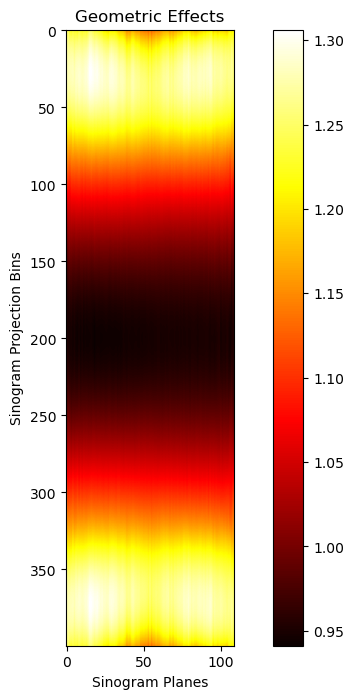

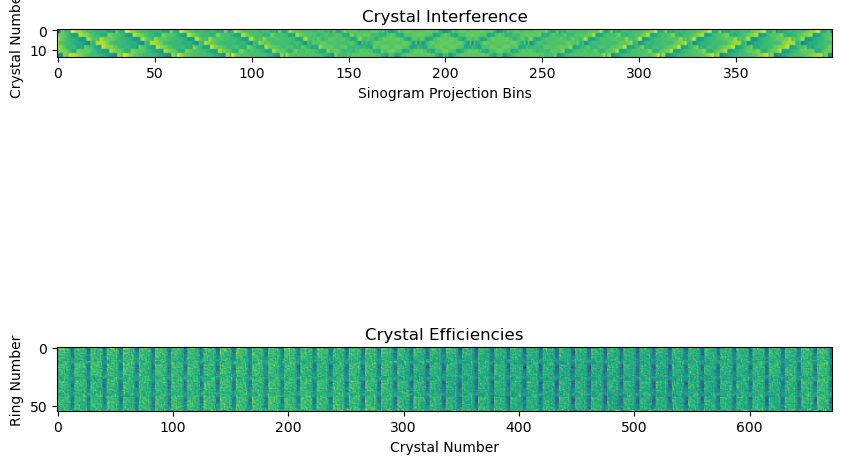

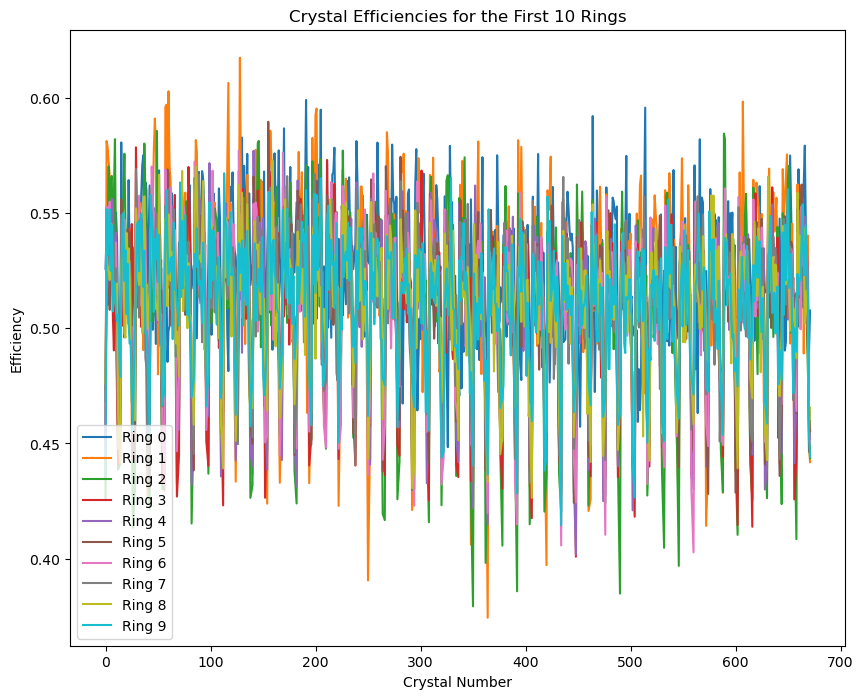

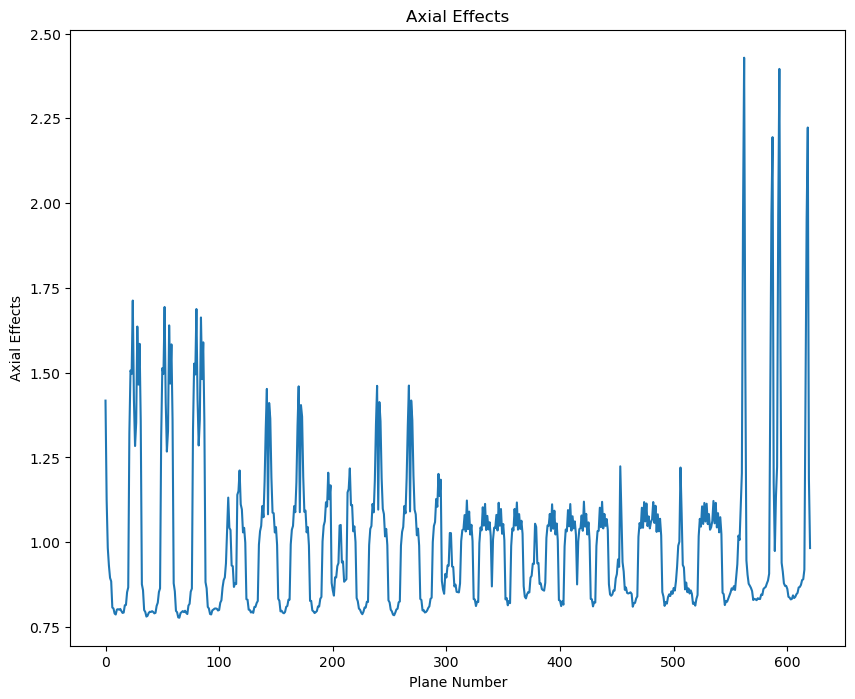

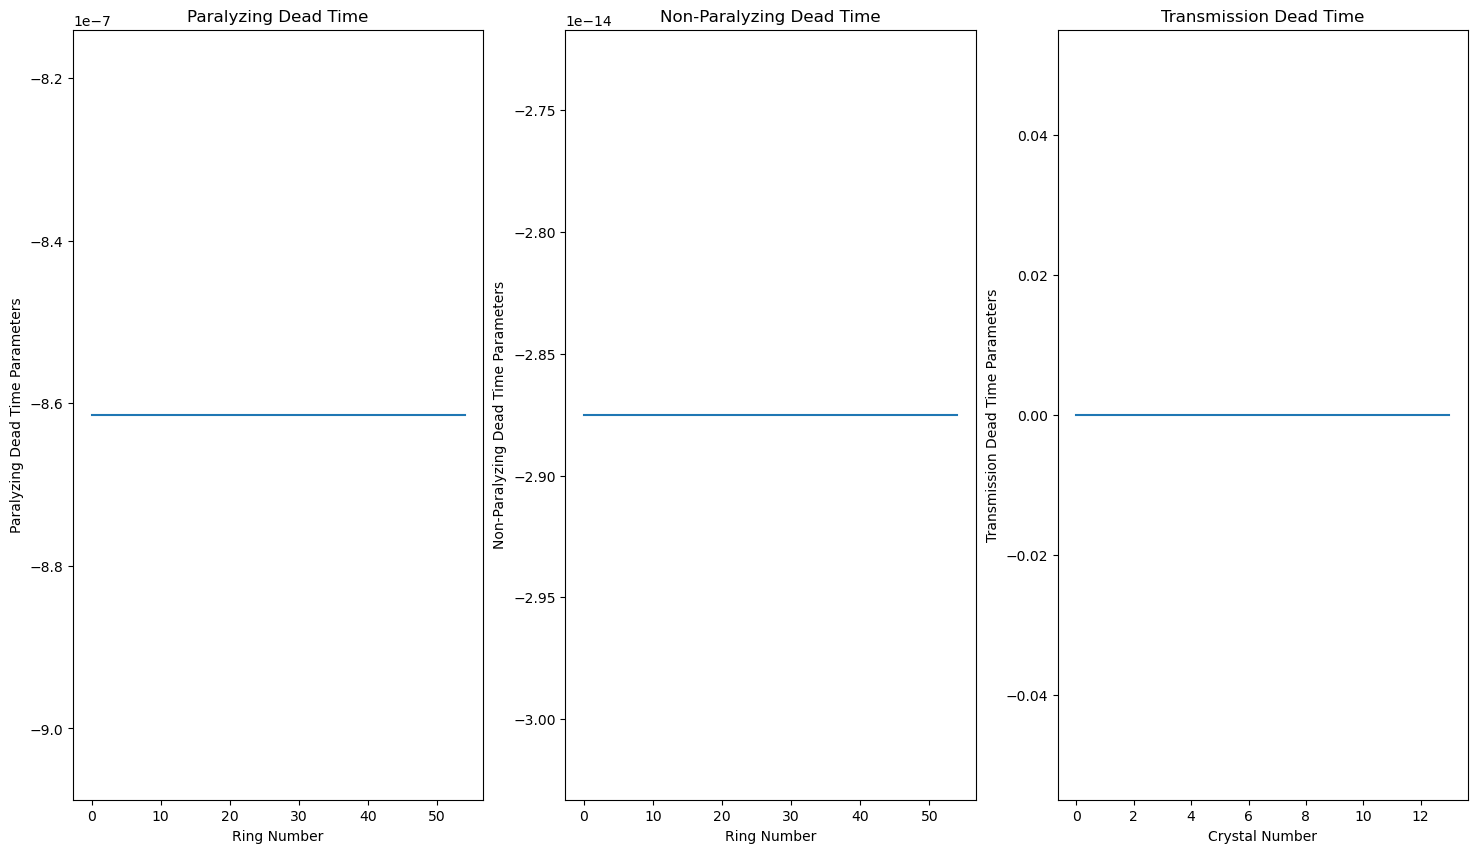

In [7]:
componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/data/PSKTH0107/output/PET-RAW-DATA-norm.n', 1)

## 4. Some Functions to Implement Component_based Normalization Algorithm

In [8]:
def getSizeSino3dStruct(numR, numTheta, numZ, rFov, zFov, sinogramsPerSegment, minRingDiff, maxRingDiff, maxAbsRingDiff=None):
    if maxAbsRingDiff is None:
        maxAbsRingDiff = numZ

    # Generate a vector with r values:
    deltaR = (2 * rFov) / numR
    rValues_mm = np.arange(-(rFov - deltaR/2), (rFov - deltaR/2) + deltaR, deltaR)

    # Generate a vector with theta values:
    deltaTheta = 180 / numTheta
    thetaValues_deg = np.arange(deltaTheta/2, 180 - deltaTheta/2 + deltaTheta, deltaTheta)

    # Generate a vector with z values:
    deltaZ = zFov / numZ
    zValues_mm = np.arange(-(zFov/2 - deltaZ/2), (zFov/2 - deltaZ/2) + deltaZ, deltaZ)

    # Calculate the number of segments:
    numSegments = len(sinogramsPerSegment)

    # Calculate the span using the ring difference from the first segment:
    span = (maxRingDiff[0] - minRingDiff[0]) + 1

    # Calculate the number of sinograms for each segment:
    sinogramsPerSegmentAux = np.zeros(numSegments, dtype=int)
    numRings = numZ
    numSinosMashed = []

    for segment in range(numSegments):
        numSinosThisSegment = 0
        for z1 in range(1, numRings*2 + 1):
            numSinosZ1inSegment = 0
            z1_aux = z1

            for z2 in range(1, numRings + 1):
                if (z1_aux - z2) <= maxRingDiff[segment] and (z1_aux - z2) >= minRingDiff[segment]:
                    if z1_aux > 0 and z2 > 0 and z1_aux <= numRings and z2 <= numRings:
                        numSinosZ1inSegment += 1
                z1_aux -= 1

            if numSinosZ1inSegment > 0:
                numSinosMashed.append([numSinosZ1inSegment])
                numSinosThisSegment += 1

        sinogramsPerSegmentAux[segment] = numSinosThisSegment

    if not np.array_equal(sinogramsPerSegmentAux, sinogramsPerSegment):
        raise ValueError('The sinograms per segment parameter does not match with the other parameters.')

    structSizeSino3D1 = {
    'numTheta': numTheta, 'numR': numR, 'numZ': numZ, 'numSegments': numSegments, 'rFov_mm': rFov,
    'zFov_mm': zFov, 'rValues_mm': rValues_mm, 'thetaValues_deg': thetaValues_deg,
    'zValues_mm': zValues_mm, 'sinogramsPerSegment': sinogramsPerSegment, 'minRingDiff': minRingDiff,
    'maxRingDiff': maxRingDiff, 'maxAbsRingDiff': maxAbsRingDiff, 'span': span
    }
    
    return structSizeSino3D1

In [9]:
def getSizeSino3dFromSpan(numR, numTheta, numZ, rFov, zFov, span, maxAbsRingDiff):
    
    deltaR = (2 * rFov) / numR
    rValues_mm = np.arange(-(rFov - deltaR / 2), (rFov - deltaR / 2) + deltaR, deltaR)
    
    deltaTheta = 180 / numTheta
    thetaValues_deg = np.arange(deltaTheta / 2, 180 - deltaTheta / 2 + deltaTheta, deltaTheta)
    
    deltaZ = zFov / numZ
    zValues_mm = np.arange(-(zFov / 2 - deltaZ / 2), (zFov / 2 - deltaZ / 2) + deltaZ, deltaZ)

    numSinosMashed = []
    
    numSinosImpar = span // 2
    numSinosPar = np.ceil(span / 2)
    
    minRingDiffs = []
    maxRingDiffs = []
    minRingDiffsCurrent = -np.floor(span / 2)
    maxRingDiffsCurrent = np.floor(span / 2)
    minRingDiffs.append(minRingDiffsCurrent)
    maxRingDiffs.append(maxRingDiffsCurrent)
    numSegments = 1
    
    while (abs(minRingDiffs[numSegments - 1]) < maxAbsRingDiff):
        numSegments += 1
        if numSegments == 2:
            minRingDiffs.append(minRingDiffs[numSegments - 2] + span)
            if maxRingDiffs[numSegments - 2] + span <= maxAbsRingDiff:
                maxRingDiffs.append(maxRingDiffs[numSegments - 2] + span)
            else:
                maxRingDiffs[numSegments - 1] = maxAbsRingDiff
        else:
            minRingDiffs.append(minRingDiffs[numSegments - 3] + span)
            if maxRingDiffs[numSegments - 3] + span <= maxAbsRingDiff:
                maxRingDiffs.append(maxRingDiffs[numSegments - 3] + span)
            else:
                maxRingDiffs[numSegments - 1] = maxAbsRingDiff
        
        numSegments += 1
        maxRingDiffs.append(maxRingDiffs[numSegments - 3] - span)
        if abs(minRingDiffs[numSegments - 3] - span) <= maxAbsRingDiff:
            minRingDiffs.append(minRingDiffs[numSegments - 3] - span)
        else:
            minRingDiffs[numSegments - 1] = -maxAbsRingDiff
    
    sinogramsPerSegment = np.zeros(numSegments, dtype=int)
    numRings = numZ
    segments = []
    
    for segment in range(numSegments):
        numSinosThisSegment = 0
        z1_values = []
        z2_values = []
        
        for z1 in range(1, numRings * 2 + 1):
            numSinosZ1inSegment = 0
            z1_aux = z1
            meanZ1 = 0
            meanZ2 = 0
            
            for z2 in range(1, numRings + 1):
                if (z1_aux - z2) <= maxRingDiffs[segment] and (z1_aux - z2) >= minRingDiffs[segment]:
                    if z1_aux > 0 and z2 > 0 and z1_aux <= numRings and z2 <= numRings:
                        numSinosZ1inSegment += 1
                        meanZ1 += z1_aux
                        meanZ2 += z2
                z1_aux -= 1
            
            if numSinosZ1inSegment > 0:
                meanZ1 /= numSinosZ1inSegment
                meanZ2 /= numSinosZ1inSegment
                numSinosMashed.append(numSinosZ1inSegment)
                numSinosThisSegment += 1
                z1_values.append(meanZ1)
                z2_values.append(meanZ2)
                
        segments.append({'z1': z1_values, 'z2': z2_values})
        
        sinogramsPerSegment[segment] = numSinosThisSegment
        
    structSizeSino3D1 = getSizeSino3dStruct(numR, numTheta, numZ, rFov, zFov, sinogramsPerSegment, minRingDiffs, maxRingDiffs, maxAbsRingDiff);
    structSizeSino3D2 = {
        'numSinosMashed': numSinosMashed,
        'segments': segments
    }
    structSizeSino3D = {**structSizeSino3D1, **structSizeSino3D2}
    
    return structSizeSino3D

In [10]:
def generateMichelogramFromSinogram3D(sinogram3d, structSizeSino3d):
    numR = structSizeSino3d['numR']
    numTheta = structSizeSino3d['numTheta']
    numZ = structSizeSino3d['numZ']
    numSegments = structSizeSino3d['numSegments']
    maxAbsRingDiff = structSizeSino3d['maxAbsRingDiff']
    minRingDiff = structSizeSino3d['minRingDiff']
    maxRingDiff = structSizeSino3d['maxRingDiff']
    sinogramsPerSegment = structSizeSino3d['sinogramsPerSegment']
    
    michelogram = np.zeros((numR, numTheta, numZ, numZ))
    
    indiceSino = 1
    
    for segment in range(1, numSegments + 1):
        numSinosThisSegment = 0
        
        for z1 in range(1, (numZ * 2) + 1):
            numSinosZ1inSegment = 0
            z1_aux = z1
            
            for z2 in range(1, numZ + 1):
                if (z1_aux - z2) <= maxRingDiff[segment - 1] and (z1_aux - z2) >= minRingDiff[segment - 1]:
                    if (z1_aux > 0) and (z2 > 0) and (z1_aux <= numZ) and (z2 <= numZ):
                        numSinosZ1inSegment += 1
                        michelogram[:, :, z1_aux - 1, z2 - 1] = sinogram3d[:, :, indiceSino-1]
                z1_aux -= 1
            
            if numSinosZ1inSegment > 0:
                numSinosThisSegment += 1
                indiceSino += 1
        
        if numSinosThisSegment != sinogramsPerSegment[segment - 1]:
            print(f"The amount of sinograms in segment {segment} is different than expected.")
    
    if indiceSino != (np.sum(sinogramsPerSegment) + 1):
        print("Error: The number of written sinograms is different from the sum of sinograms per segment.")
        
    return michelogram

In [11]:
def reduceMichelogram(michelogram, structSizeSino):
    sinogram3D = np.zeros((structSizeSino['numR'], structSizeSino['numTheta'], np.sum(structSizeSino['sinogramsPerSegment'])))
    
    if (len(structSizeSino['sinogramsPerSegment']) != len(structSizeSino['minRingDiff'])) or (len(structSizeSino['sinogramsPerSegment']) != len(structSizeSino['maxRingDiff'])):
        print('Error: The vectors sinogramsPerSegment, minRingDiff, maxRingDiff must be the same size')
        return None, None
    
    if michelogram.shape[2] != michelogram.shape[3]:
        print('Error: The michelogram does not have the same number of rings for z1 as for z2')
        return None, None
    
    indiceSino = 1
    
    for segment in range(1, structSizeSino['numSegments']+1):
        numSinosThisSegment = 0
        for z1 in range(1, (structSizeSino['numZ']*2)+1):
            numSinosZ1inSegment = 0
            z1_aux = z1
            for z2 in range(1, structSizeSino['numZ']+1):
                if (z1_aux - z2) <= structSizeSino['maxRingDiff'][segment-1] and (z1_aux - z2) >= structSizeSino['minRingDiff'][segment-1]:
                    if z1_aux > 0 and z2 > 0 and z1_aux <= structSizeSino['numZ'] and z2 <= structSizeSino['numZ']:
                        numSinosZ1inSegment += 1
                        sinogram3D[:, :, indiceSino-1] += michelogram[:, :, z1_aux-1, z2-1]
                z1_aux -= 1
            if numSinosZ1inSegment > 0:
                numSinosThisSegment += 1
                indiceSino += 1
    
    if indiceSino != (np.sum(structSizeSino['sinogramsPerSegment']) + 1):
        print('Error: The number of written sinograms is different from the sum of the sinograms per segment.')
        return None, None
    
    return sinogram3D

In [12]:
def convertSinogramToSpan(sinogram, structSizeSino3d, outputSpan):
    # Create sinogram span N:
    michelogram = generateMichelogramFromSinogram3D(sinogram, structSizeSino3d)
    
    numR = structSizeSino3d['numR']
    numTheta = structSizeSino3d['numTheta']
    numZ = structSizeSino3d['numZ']
    rFov_mm = structSizeSino3d['rFov_mm']
    zFov_mm = structSizeSino3d['zFov_mm']
    maxAbsRingDiff = structSizeSino3d['maxAbsRingDiff']
    
    structSizeSino3dSpanN = getSizeSino3dFromSpan(numR, numTheta, numZ, rFov_mm, zFov_mm, outputSpan, maxAbsRingDiff)
    sinogramSpanN = reduceMichelogram(michelogram, structSizeSino3dSpanN)
    
    return sinogramSpanN, structSizeSino3dSpanN

In [13]:
def get_uncompressed_angles(angle_num, mash_factor=2):
    """ Returns the decompressed angles, taking into accound the mash_factor.
        The default value for the mash factor is 2. """
    # uncompress the angle_num
    actual_angle = angle_num * mash_factor
   
    actual_angles = []
    for i in range(mash_factor):
        actual_angles.append(actual_angle + i)
   
    return np.array(actual_angles)

In [14]:
def get_radial_offset(radial_num, num_proj=400):
    """ Converts the radial number to a radial offset (offset from middle projection) """
    # get the radial offset
    radial_offset = radial_num - num_proj //2
           
    return radial_offset

In [15]:
def get_detector_pair(angle, element, ncrystals=14*12*4):
    """
    Calculate the crystal/detector pair of a LOR
    input angle is the uncompressed angle
    input element is the radial offset
    Default values are for mCT scanner
    """
    nangles = ncrystals // 2
    d1 = angle
    d2 = angle + nangles
    d1 = d1 + element // 2
    d2 = d2 - (element + 1)//2
    d1 = d1 % ncrystals
    d2 = d2 % ncrystals
    if d1 > d2:
        d1, d2 = d2, d1
    
    return d1, d2

In [16]:
def get_crystal_pairs(angle_num, radial_num, ncrystals=14*12*4):
    """
    Get all crystal pairs (d1, d2) for the radial_offset (i.e. from the LOR, after shifting) and each of the uncompressed angles
    Default value for ncrystals is for mCT scanner
    """
    actual_angles = get_uncompressed_angles(angle_num)
    radial_offset = get_radial_offset(radial_num)
    
    crystal_pairs = []
    for k in actual_angles:
        crystal_pairs.append(get_detector_pair(k, radial_offset, ncrystals))   
           
    return crystal_pairs

In [17]:
d00_total =np.zeros((400,168))
d01_total =np.zeros((400,168))
d10_total =np.zeros((400,168))
d11_total =np.zeros((400,168))

for i in range (0, 400):
    for j in range(0, 168):
        d00_total[i,j]=get_crystal_pairs(j, i, 14*12*4)[0][0]
        d01_total[i,j]=get_crystal_pairs(j, i, 14*12*4)[0][1]
        d10_total[i,j]=get_crystal_pairs(j, i, 14*12*4)[1][0]
        d11_total[i,j]=get_crystal_pairs(j, i, 14*12*4)[1][1]
        
d00_total = d00_total.astype(np.int64)
d01_total = d01_total.astype(np.int64)
d10_total = d10_total.astype(np.int64)
d11_total = d11_total.astype(np.int64)

In [18]:
def createSinogram3dFromDetectorsEfficency(efficenciesPerDetector, structSizeSino3d):

    numDetectors = efficenciesPerDetector.shape[0]
    numRings = efficenciesPerDetector.shape[1]
    
    if numRings != structSizeSino3d['numZ']:
        raise ValueError('The number of rings in the sinogram is different from the rings in the crystal efficencies.')
    
    sinoEfficencies = np.zeros((structSizeSino3d['numR'], structSizeSino3d['numTheta'], np.sum(structSizeSino3d['sinogramsPerSegment'])))

    detectorIds = np.arange(1, numDetectors + 1)
    rings = np.arange(1, numRings + 1)
    
       
    indiceSino = 1
    for segment in range(1, structSizeSino3d['numSegments'] + 1):
        numSinosThisSegment = 0
        for z1 in range(1, structSizeSino3d['numZ'] * 2 + 1):
            numSinosZ1inSegment = 0
            z1_aux = z1
            for z2 in range(1, structSizeSino3d['numZ'] + 1):
                if (z1_aux - z2) <= structSizeSino3d['maxRingDiff'][segment - 1] and (z1_aux - z2) >= structSizeSino3d['minRingDiff'][segment - 1]:
                    if (z1_aux > 0) and (z2 > 0) and (z1_aux <= structSizeSino3d['numZ']) and (z2 <= structSizeSino3d['numZ']):
                        
                        numSinosZ1inSegment += 1
                        efficenciesZ1 = efficenciesPerDetector[:, z1_aux - 1]
                        efficenciesZ2 = efficenciesPerDetector[:, z2 - 1]
                        sinoEfficencies[:, :, indiceSino-1] += (efficenciesZ1[d00_total-1] * efficenciesZ2[d01_total-1] + efficenciesZ1[d10_total-1] * efficenciesZ2[d11_total-1])
                        
                        
                z1_aux -= 1
            if numSinosZ1inSegment > 0:
                sinoEfficencies[:, :, indiceSino-1] /= numSinosZ1inSegment
                numSinosThisSegment += 1
                indiceSino += 1
    return sinoEfficencies

## 5. Geometry Component

In [19]:
def create_norm_files_geometry_mct(cbn_filename):
        
    # 1) Read the .n files and get each component in a cell array:
    if cbn_filename:
        componentFactors, componentLabels = readmCTComponentBasedNormalization(cbn_filename, 0)
    else:
        
        componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/data/PSKTH0107/output/PET-RAW-DATA-norm.n', 0)
        #componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/PET_Image_Reconstruction/Reconstruction/mCTTestData-norm.n', 0)
    
    # 2) Size of the mct's sinograms.
    numTheta = 168
    numR = 400
    numRings = 55
    maxAbsRingDiff = 49
    rFov_mm = 704
    zFov_mm = 218
    #zFov_mm = 221
    
    structSizeSino3d = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 11, maxAbsRingDiff)
    
    structSizeSino3d_span1 = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 1, maxAbsRingDiff)
    numSinograms = np.sum(structSizeSino3d['sinogramsPerSegment'])
    
     
        
    # 4) Generate the scan_independent_ncf_3d
    geometricFactor = (np.tile(componentFactors[0][:, 0], (structSizeSino3d['numTheta'], 1))).T

    geometry_ncf_3d = np.zeros((numR, numTheta, numSinograms))
    
    for i in range(1, np.sum(structSizeSino3d['sinogramsPerSegment'])+1):
        geometry_ncf_3d[:,:,i-1] = 1/ (geometricFactor)
        
    return geometry_ncf_3d

## 6. Interference and Axial Components

In [20]:
def create_norm_files_interferenceAndaxialeffects_mct(cbn_filename):
    
    # 1) Read the .n files and get each component in a cell array:
    if cbn_filename:
        componentFactors, componentLabels = readmCTComponentBasedNormalization(cbn_filename, 0)
    else:
        
        componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/data/PSKTH0107/output/PET-RAW-DATA-norm.n', 0)
        #componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/PET_Image_Reconstruction/Reconstruction/mCTTestData-norm.n', 0)
    
    # 2) Size of the mct's sinograms.
    numTheta = 168
    numR = 400
    numRings = 55
    maxAbsRingDiff = 49
    rFov_mm = 704
    zFov_mm = 218
    #zFov_mm = 221
    
    structSizeSino3d = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 11, maxAbsRingDiff)
    
    structSizeSino3d_span1 = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 1, maxAbsRingDiff)
    numSinograms = np.sum(structSizeSino3d['sinogramsPerSegment'])
    
    crystalInterfFactor1 = np.float32(componentFactors[1])
       
    crystalInterfFactor = np.tile(crystalInterfFactor1.T[:, 0::2], (1, 2*int(structSizeSino3d['numTheta'] / crystalInterfFactor1.shape[0])))   
     
    axialFactors = np.array(structSizeSino3d['numSinosMashed']).T * (1 / componentFactors[3])  # e7 tools does not use the other component factors * componentFactors[7]

    interferenceAndaxialeffects_ncf_3d = np.zeros((numR, numTheta, numSinograms))
    
    for i in range(1, np.sum(structSizeSino3d['sinogramsPerSegment'])+1):
        interferenceAndaxialeffects_ncf_3d[:,:,i-1] = 1 / crystalInterfFactor
        interferenceAndaxialeffects_ncf_3d[:,:,i-1] *= 1 / axialFactors[i-1]
        
    return interferenceAndaxialeffects_ncf_3d

## 7. Efficiency Component

In [21]:
def create_norm_files_efficiency_mct(cbn_filename):
        
    # 1) Read the .n files and get each component in a cell array:
    if cbn_filename:
        componentFactors, componentLabels = readmCTComponentBasedNormalization(cbn_filename, 0)
    else:
        
        componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/data/PSKTH0107/output/PET-RAW-DATA-norm.n', 0)
        #componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/PET_Image_Reconstruction/Reconstruction/mCTTestData-norm.n', 0)
    
    # 2) Size of the mct's sinograms.
    numTheta = 168
    numR = 400
    numRings = 55
    maxAbsRingDiff = 49
    rFov_mm = 704
    zFov_mm = 218
    #zFov_mm = 221
    
    structSizeSino3d = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 11, maxAbsRingDiff)
    
    structSizeSino3d_span1 = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 1, maxAbsRingDiff)
    numSinograms = np.sum(structSizeSino3d['sinogramsPerSegment'])
    
    scanner_efficiency_ncf_3d = np.zeros((numR, numTheta, numSinograms))
    
    # 3) Selection of dead-time parameters and crystal efficencies:
    used_xtal_efficiencies = componentFactors[2]
    used_xtal_efficiencies[0::14, :] = 0 # fOR mCT
        
    
    scanner_efficiency_nf_3d = createSinogram3dFromDetectorsEfficency(used_xtal_efficiencies, structSizeSino3d_span1)
    nonzeros = scanner_efficiency_nf_3d != 0
    scanner_efficiency1_ncf_3d = scanner_efficiency_nf_3d.copy()
    scanner_efficiency1_ncf_3d[nonzeros] = 1 / scanner_efficiency_nf_3d[nonzeros]
                
    scanner_efficiency1_ncf_3d, structSizeSino3d_span11 = convertSinogramToSpan(scanner_efficiency1_ncf_3d, structSizeSino3d_span1, structSizeSino3d['span'])
        
    for i in range(1, sum(structSizeSino3d['sinogramsPerSegment']) + 1):
        scanner_efficiency1_ncf_3d[:, :, i-1] /= structSizeSino3d['numSinosMashed'][i-1]
        

    return scanner_efficiency1_ncf_3d

## 8. Total Component

In [22]:
def create_norm_files_mct(cbn_filename):
    
    used_xtal_efficiencies = []
    used_axial_factors = []
    
    # 1) Read the .n files and get each component in a cell array:
    if cbn_filename:
        componentFactors, componentLabels = readmCTComponentBasedNormalization(cbn_filename, 0)
    else:
        
        componentFactors, componentLabels = readmCTComponentBasedNormalization('/home/hamidreza/data/PSKTH0107/output/PET-RAW-DATA-norm.n', 0)
    
    # 2) Size of the mct's sinograms.
    numTheta = 168
    numR = 400
    numRings = 55
    maxAbsRingDiff = 49
    rFov_mm = 704
    zFov_mm = 218
    #zFov_mm = 221
    
    
    structSizeSino3d = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 11, maxAbsRingDiff)
    
    structSizeSino3d_span1 = getSizeSino3dFromSpan(numR, numTheta, numRings, rFov_mm, zFov_mm, 1, maxAbsRingDiff)
    numSinograms = np.sum(structSizeSino3d['sinogramsPerSegment'])
    
    overall_ncf_3d = np.zeros((numR, numTheta, numSinograms))
    scanner_time_invariant_ncf_3d = np.zeros((numR, numTheta, numSinograms))
    scanner_time_variant_ncf_3d = np.zeros((numR, numTheta, numSinograms))
        
    # 3) Selection crystal efficencies:
    used_xtal_efficiencies = componentFactors[2]
    used_xtal_efficiencies[0::14, :] = 0 # fOR mCT
       
      
    # 4) Generate the scan_independent_ncf_3d
    geometricFactor = (np.tile(componentFactors[0][:, 0], (structSizeSino3d['numTheta'], 1))).T
    crystalInterfFactor1 = np.float32(componentFactors[1])
    crystalInterfFactor = np.tile(crystalInterfFactor1.T[:, 0::2], (1, 2*int(structSizeSino3d['numTheta'] / crystalInterfFactor1.shape[0])))   

    axialFactors = np.zeros(np.sum(structSizeSino3d_span1['sinogramsPerSegment']))
        
    axialFactors = np.array(structSizeSino3d['numSinosMashed']).T * (1 / componentFactors[3])
    
    for i in range(1, np.sum(structSizeSino3d['sinogramsPerSegment'])+1):
        scanner_time_invariant_ncf_3d[:,:,i-1] = 1/ (geometricFactor * crystalInterfFactor)
        scanner_time_invariant_ncf_3d[:,:,i-1] *= 1/ axialFactors[i-1]
        
    scanner_time_variant_nf_3d = createSinogram3dFromDetectorsEfficency(used_xtal_efficiencies, structSizeSino3d_span1)
    nonzeros = scanner_time_variant_nf_3d != 0
    scanner_time_variant_ncf_3d = scanner_time_variant_nf_3d.copy()
    scanner_time_variant_ncf_3d[nonzeros] = 1 / scanner_time_variant_nf_3d[nonzeros]

        
    scanner_time_variant_ncf_3d, structSizeSino3d_span11 = convertSinogramToSpan(scanner_time_variant_ncf_3d, structSizeSino3d_span1, structSizeSino3d['span'])
    
    
    for i in range(1, sum(structSizeSino3d['sinogramsPerSegment']) + 1):
        scanner_time_variant_ncf_3d[:, :, i-1] /= structSizeSino3d['numSinosMashed'][i-1]
            

    overall_ncf_3d = scanner_time_invariant_ncf_3d * scanner_time_variant_ncf_3d

    return overall_ncf_3d

## 9. Creation of the Different Components

In [23]:
geometry_ncf_3d = create_norm_files_geometry_mct(None)

In [24]:
interferenceAndaxialeffects_ncf_3d = create_norm_files_interferenceAndaxialeffects_mct(None)

In [25]:
efficiency_ncf_3d = create_norm_files_efficiency_mct(None)

In [26]:
overall_ncf_3d = create_norm_files_mct(None)

In [27]:
overall_ncf_3d.shape

(400, 168, 621)

In [28]:
np.sum(overall_ncf_3d==0)

417312

In [29]:
geometry_nf_3d = geometry_ncf_3d.copy()
non_zero_indices = geometry_ncf_3d != 0
geometry_nf_3d[non_zero_indices] = 1.0 / geometry_ncf_3d[non_zero_indices]
geometry_nf_3d = geometry_nf_3d.T

In [30]:
interferenceAndaxialeffects_nf_3d = interferenceAndaxialeffects_ncf_3d.copy()
non_zero_indices = interferenceAndaxialeffects_ncf_3d != 0
interferenceAndaxialeffects_nf_3d[non_zero_indices] = 1.0 / interferenceAndaxialeffects_ncf_3d[non_zero_indices]
interferenceAndaxialeffects_nf_3d = interferenceAndaxialeffects_nf_3d.T

In [31]:
efficiency_nf_3d = efficiency_ncf_3d.copy()
non_zero_indices = efficiency_ncf_3d != 0
efficiency_nf_3d[non_zero_indices] = 1.0 / efficiency_ncf_3d[non_zero_indices]
efficiency_nf_3d = efficiency_nf_3d.T

In [32]:
overall_nf_3d = overall_ncf_3d.copy()
non_zero_indices = overall_ncf_3d != 0
overall_nf_3d[non_zero_indices] = 1.0 / overall_ncf_3d[non_zero_indices]
overall_nf_3d = overall_nf_3d.T

In [33]:
rows, columns, slices = np.where(overall_nf_3d==0)
slices

array([ 17,  19,  45, ..., 355, 381, 383])

In [34]:
rows, columns = np.where(overall_nf_3d[:,:,17] ==0)
columns

array([  4,  11,  18, ..., 151, 158, 165])

In [35]:
rows, columns = np.where(overall_nf_3d[:,:,17] ==0)
rows

array([  0,   0,   0, ..., 620, 620, 620])

In [36]:
norm3d_file = "norm3d_00.a"

In [37]:
with open(norm3d_file, 'rb') as f:
    tmp=np.fromfile(f, dtype=np.float32)
norm3d = np.reshape(tmp, newshape=(621,168,400))

In [38]:
inv_norm3d = norm3d.copy()
non_zero_indices = norm3d != 0
inv_norm3d[non_zero_indices] = 1.0 / norm3d[non_zero_indices]

In [39]:
np.sum(inv_norm3d==0)

417312

In [40]:
rows, columns, slices = np.where(inv_norm3d==0)
slices

array([ 17,  19,  45, ..., 355, 381, 383])

In [41]:
rows, columns = np.where(inv_norm3d[:,:,17] ==0)
columns

array([  3,  10,  17, ..., 150, 157, 164])

In [42]:
rows, columns = np.where(inv_norm3d[:,:,17] ==0)
rows

array([  0,   0,   0, ..., 620, 620, 620])

## 10. Visualiztion of the Different Components in Comparizon With e7-tools

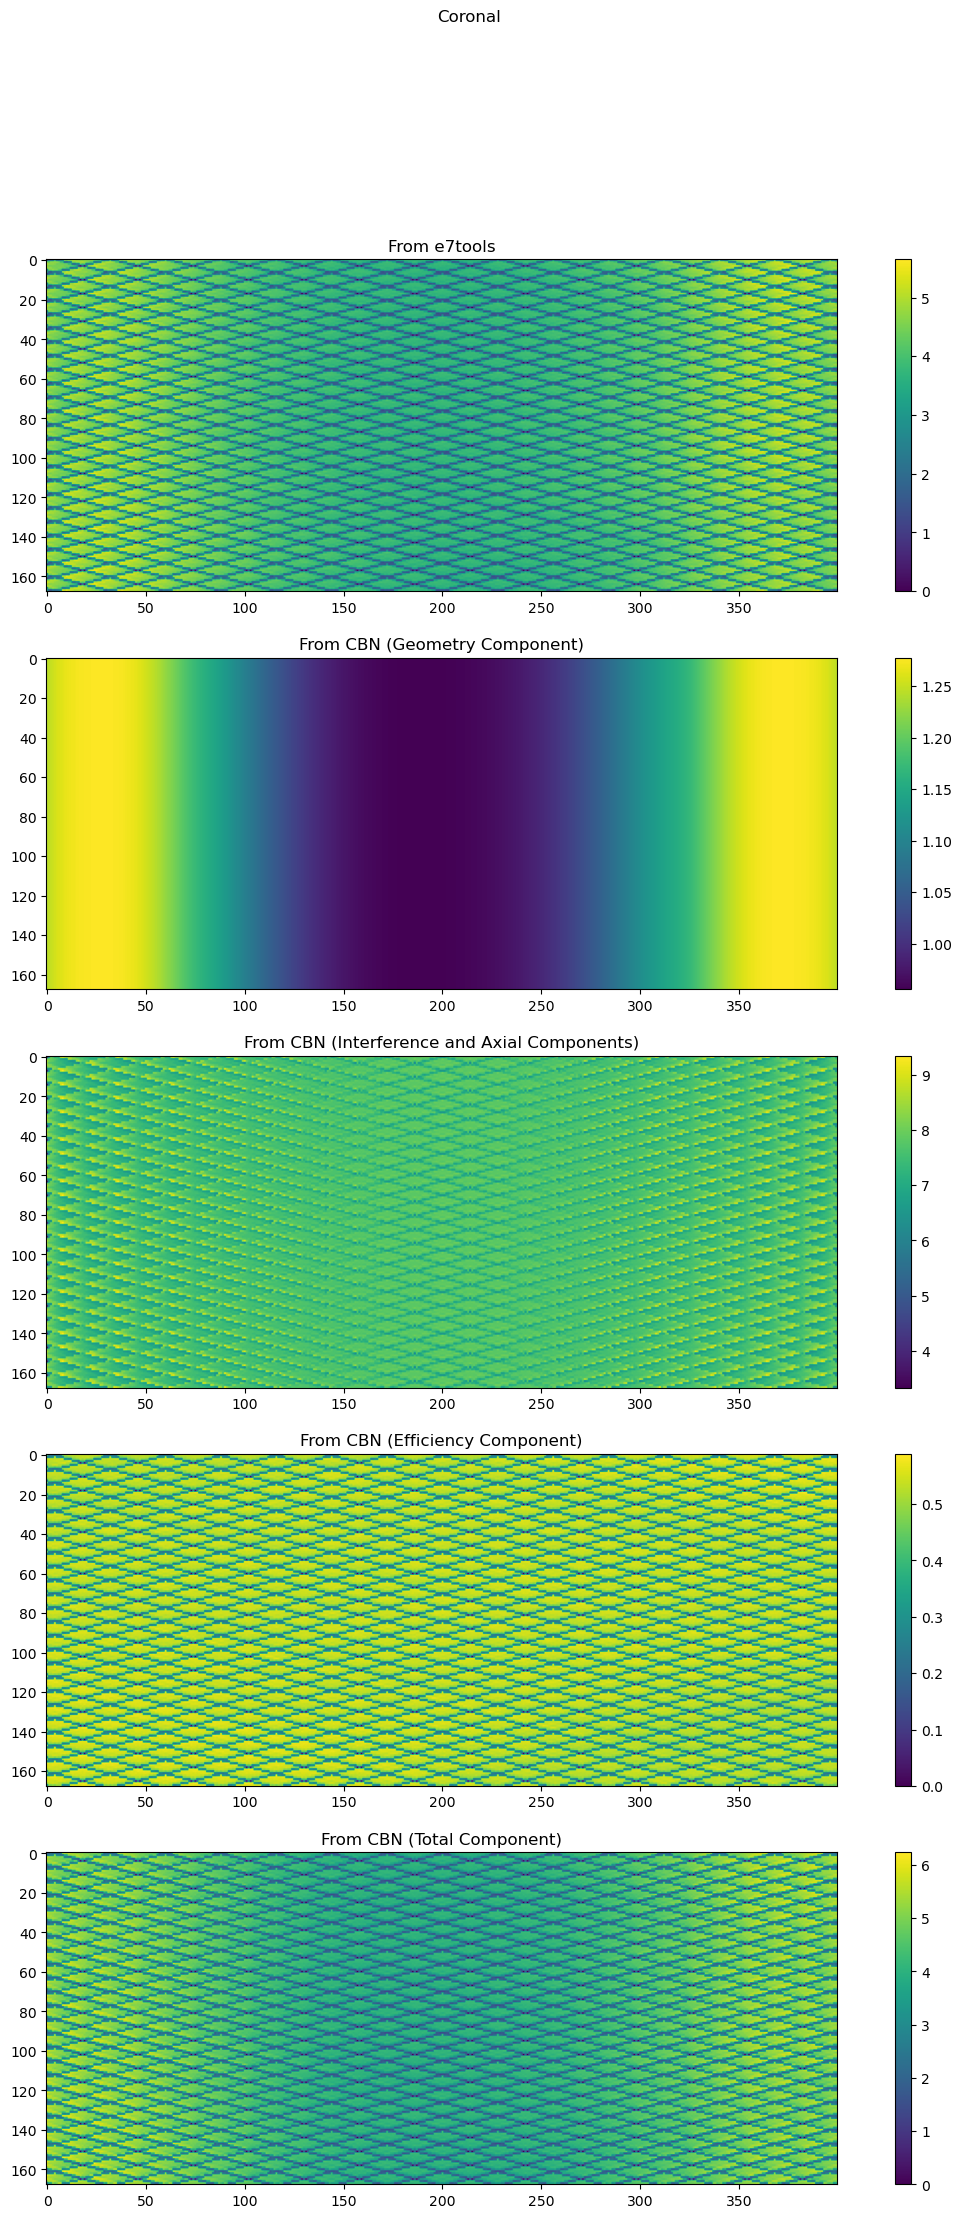

In [43]:
z = 71
plt.rcParams['figure.figsize']=[15, 25]
plt.figure()
plt.suptitle('Coronal')

plt.subplot(5,1,1)
plt.imshow(inv_norm3d[z])
plt.title('From e7tools')
plt.colorbar()

plt.subplot(5,1,2)
plt.imshow(geometry_nf_3d[z])
plt.title('From CBN (Geometry Component)')
plt.colorbar()

plt.subplot(5,1,3)
plt.imshow(interferenceAndaxialeffects_nf_3d[z])
plt.title('From CBN (Interference and Axial Components)')
plt.colorbar()

plt.subplot(5,1,4)
plt.imshow(efficiency_nf_3d[z])
plt.title('From CBN (Efficiency Component)')
plt.colorbar()

plt.subplot(5,1,5)
plt.imshow(overall_nf_3d[z])
plt.title('From CBN (Total Component)')
plt.colorbar()

## 11. Reconstruction of the Created Normalization Matrix

In [44]:
template_non_TOF1 = AcquisitionData('Siemens_mCT',span=11, max_ring_diff=49, view_mash_factor=2,tof_mash_factor=13)
template_non_TOF1.get_info()

'ProjDataInfoCylindricalNoArcCorr := \nScanner parameters:= \nScanner type := Siemens mCT\nNumber of rings                          := 55\nNumber of detectors per ring             := 672\nInner ring diameter (cm)                 := 85.52\nAverage depth of interaction (cm)        := 0.96\nDistance between rings (cm)              := 0.4054\nDefault bin size (cm)                    := 0.2005\nView offset (degrees)                    := 0\nMaximum number of non-arc-corrected bins := 400\nDefault number of arc-corrected bins     := 400\nEnergy resolution := 0\nReference energy (in keV) := 511\nNumber of TOF time bins :=13\nSize of timing bin (ps) :=312.5\nTiming resolution (ps) :=540\nNumber of blocks per bucket in transaxial direction         := 1\nNumber of blocks per bucket in axial direction              := 4\nNumber of crystals per block in axial direction             := 14\nNumber of crystals per block in transaxial direction        := 14\nNumber of detector layers                    

In [45]:
CBN_det_eff = template_non_TOF1.fill(np.array([overall_nf_3d]))

In [46]:
img_templ = ImageData(template_non_TOF1)

In [47]:
acq_model1 = AcquisitionModelUsingRayTracingMatrix()
acq_model1.set_up(template_non_TOF1, img_templ)

In [48]:
%%time
bwd_proj_CBN_det_eff = acq_model1.backward(CBN_det_eff)

CPU times: user 13min 44s, sys: 33.1 s, total: 14min 17s
Wall time: 33.3 s


In [49]:
bwd_proj_CBN_det_eff_arr = bwd_proj_CBN_det_eff.as_array()
bwd_proj_CBN_det_eff_arr.shape

(109, 353, 353)

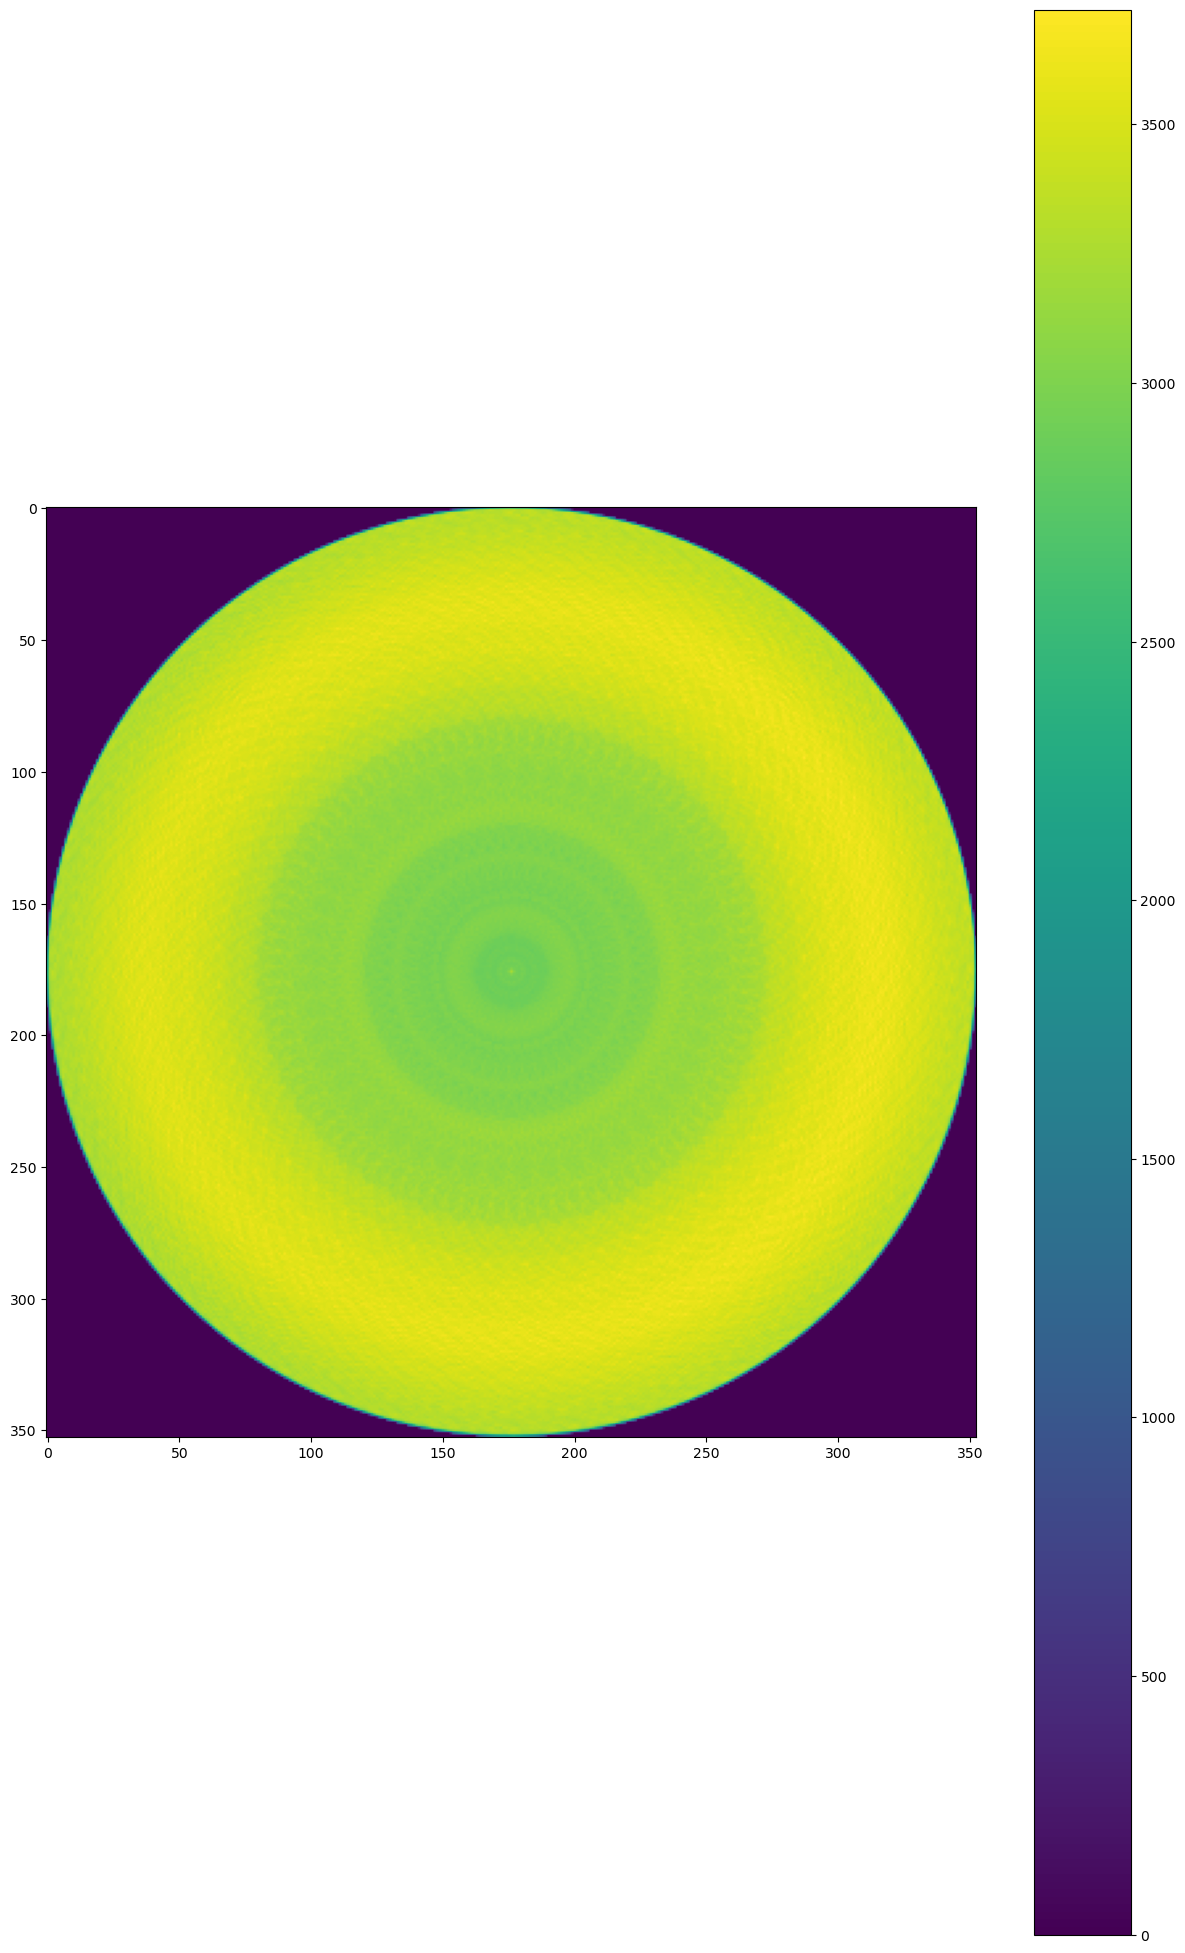

In [50]:
z = 71
plt.imshow(bwd_proj_CBN_det_eff_arr[z])
plt.colorbar()